<a href="https://colab.research.google.com/github/AlbertV100/Spring/blob/main/TweetEval_TFIDF_vs_Transformer_ProductionReady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TweetEval Sentiment — TF‑IDF Baseline vs Fine‑Tuned Transformer (Production‑Ready Colab)

This notebook compares two approaches on the **TweetEval / sentiment** dataset:

1) **Classical baseline**: TF‑IDF + Linear classifier  
2) **Modern baseline**: Fine‑tuned Transformer (Twitter‑pretrained RoBERTa)

It is designed to be:
- **simple & readable**
- **fully reproducible**
- **end‑to‑end** (data → EDA → preprocessing → modeling → evaluation → error analysis)

**Metrics reported**
- Accuracy
- Macro Precision / Macro Recall / **Macro F1**
- Confusion matrices + per-class classification reports

> Note: TweetEval sentiment is sometimes reported with different “official” metrics in papers; this notebook reports macro‑F1 and macro‑recall so that the rubric specifications are aligned.

In [ ]:

#@title Install dependencies
!pip -q install datasets scikit-learn transformers accelerate evaluate matplotlib seaborn wordcloud emoji --progress-bar off


In [ ]:

#@title Imports + global settings
import os, re, random, math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    f1_score
)

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed
)
from wordcloud import WordCloud
import emoji

sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

SEED = 42
random.seed(SEED); np.random.seed(SEED); set_seed(SEED)

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


## 1) Problem statement and success criteria

**Goal:** classify each tweet as **negative**, **neutral**, or **positive**.

**Success criteria in this notebook**
- Build a strong TF‑IDF baseline and report test metrics.
- Fine‑tune a transformer and show it **beats TF‑IDF** on test macro‑F1 (and show where it improves).
- Provide **EDA**, **clear plots**, and **error analysis** supporting conclusions.

## 2) Data loading (TweetEval / sentiment)

Splits:
- Train
- Validation
- Test

Labels:
- 0 = negative
- 1 = neutral
- 2 = positive

In [ ]:

ds = load_dataset("tweet_eval", "sentiment")

train_df = pd.DataFrame(ds["train"])
val_df   = pd.DataFrame(ds["validation"])
test_df  = pd.DataFrame(ds["test"])

label_names = ["negative", "neutral", "positive"]
for df in (train_df, val_df, test_df):
    df["label_name"] = df["label"].apply(lambda y: label_names[int(y)])

print({"train": len(train_df), "val": len(val_df), "test": len(test_df)})
train_df.head(3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'train': 45615, 'val': 2000, 'test': 12284}


,text,label,label_name
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral


## 3) Data quality checks (simple)

We check:
- missing text values
- duplicate raw tweets
- label distribution

In [ ]:

def quality_report(df: pd.DataFrame, name: str):
    text_raw = df["text"].astype(str)
    missing = text_raw.isna().sum()
    dup = text_raw.duplicated().sum()
    dist = df["label_name"].value_counts().reindex(label_names).fillna(0).astype(int)
    print(f"--- {name} ---")
    print("rows:", len(df), "| missing:", int(missing), "| duplicate texts:", int(dup))
    print("label distribution:", dist.to_dict())
    return dist

_ = quality_report(train_df, "train")
_ = quality_report(val_df, "val")
_ = quality_report(test_df, "test")


--- train ---
rows: 45615 | missing: 0 | duplicate texts: 29
label distribution: {'negative': 7093, 'neutral': 20673, 'positive': 17849}
--- val ---
rows: 2000 | missing: 0 | duplicate texts: 0
label distribution: {'negative': 312, 'neutral': 869, 'positive': 819}
--- test ---
rows: 12284 | missing: 0 | duplicate texts: 0
label distribution: {'negative': 3972, 'neutral': 5937, 'positive': 2375}


## 4) Preprocessing (two tracks)

We keep preprocessing **minimal** to preserve sentiment cues.

### Track A (TF‑IDF)
- URLs → `<URL>`
- Mentions → `@user`
- Keep hashtags/punctuation (often meaningful for sentiment)

### Track B (Transformer / Twitter‑RoBERTa)
- Mentions → `@user`
- URLs → `http`  
This matches common conventions used by Twitter‑pretrained RoBERTa models.

In [ ]:

URL_RE = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
MULTI_WS_RE = re.compile(r"\s+")

def preprocess_tfidf(text: str) -> str:
    text = str(text)
    text = URL_RE.sub(" <URL> ", text)
    text = MENTION_RE.sub(" @user ", text)
    text = text.replace("#", " #")
    text = MULTI_WS_RE.sub(" ", text).strip()
    return text

def preprocess_roberta(text: str) -> str:
    text = str(text)
    text = MENTION_RE.sub("@user", text)
    text = URL_RE.sub("http", text)
    text = MULTI_WS_RE.sub(" ", text).strip()
    return text

def count_emojis(text: str) -> int:
    text = str(text)
    return sum(ch in emoji.EMOJI_DATA for ch in text)

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["text_raw"] = df["text"].astype(str)
    df["text_tfidf"] = df["text_raw"].apply(preprocess_tfidf)
    df["text_roberta"] = df["text_raw"].apply(preprocess_roberta)
    df["n_tokens"] = df["text_raw"].str.split().apply(len)
    df["has_url"] = df["text_raw"].str.contains(URL_RE).astype(int)
    df["has_mention"] = df["text_raw"].str.contains(MENTION_RE).astype(int)
    df["has_hash"] = df["text_raw"].str.contains("#").astype(int)
    df["n_emojis"] = df["text_raw"].apply(count_emojis)
    return df

train_p = add_features(train_df)
val_p   = add_features(val_df)
test_p  = add_features(test_df)

train_p.head(3)[["text_raw","text_tfidf","text_roberta","label_name"]]


,text_raw,text_tfidf,text_roberta,label_name
0,"""QT @user In the original draft of the 7th boo...","""QT @user In the original draft of the 7th boo...","""QT @user In the original draft of the 7th boo...",positive
1,"""Ben Smith / Smith (concussion) remains out of...","""Ben Smith / Smith (concussion) remains out of...","""Ben Smith / Smith (concussion) remains out of...",neutral
2,Sorry bout the stream last night I crashed out...,Sorry bout the stream last night I crashed out...,Sorry bout the stream last night I crashed out...,neutral


## 5) EDA (focused, rubric-friendly)

We answer:
- Are classes balanced?
- How long are tweets?
- Do URLs/mentions/hashtags differ by class?
- What words/phrases are common per class? (quick qualitative scan)

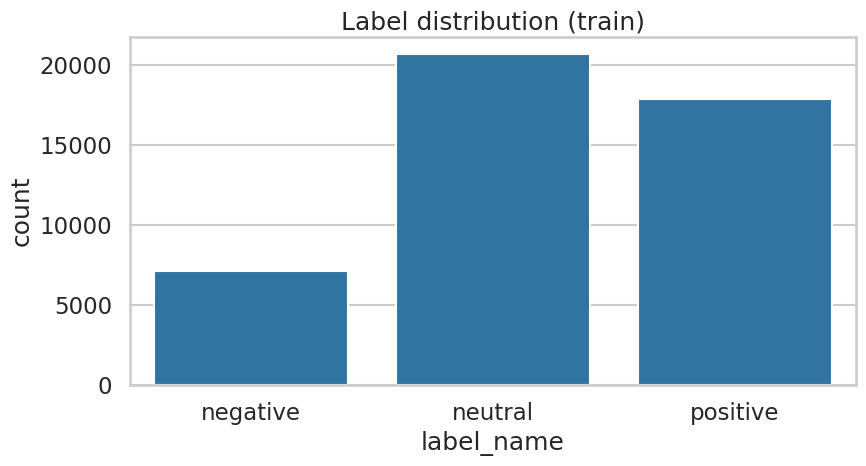

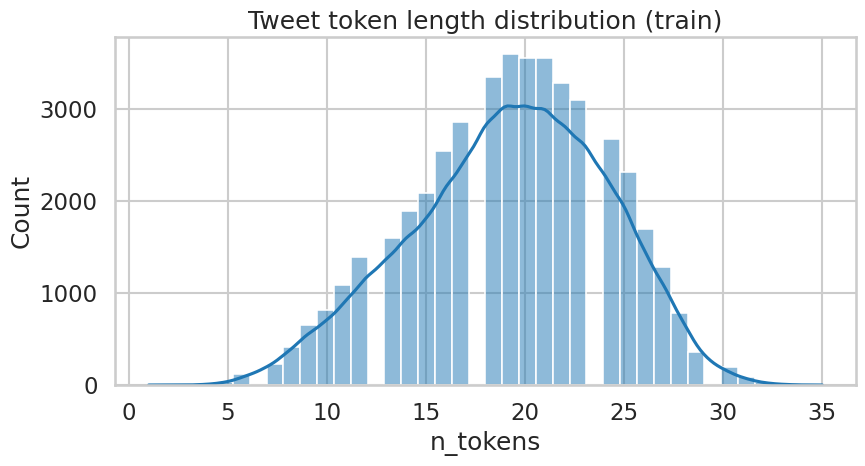

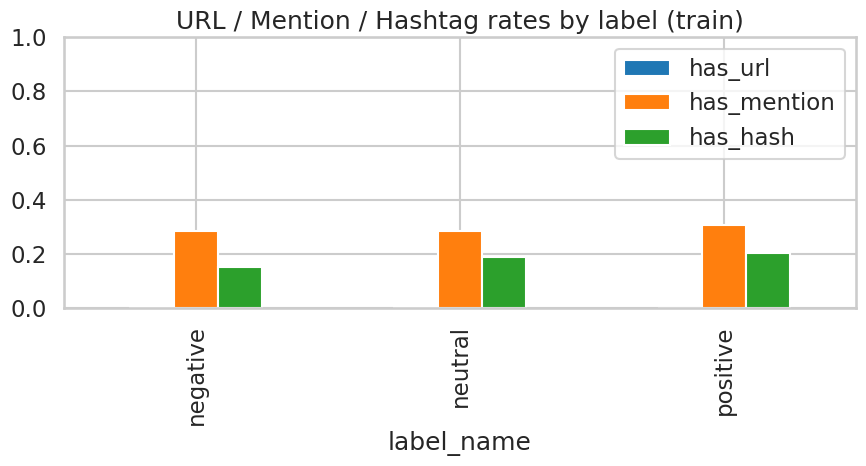

,has_url,has_mention,has_hash,n_emojis
label_name,,,,
negative,0.30%,28.65%,15.14%,0.000
neutral,0.23%,28.53%,18.73%,0.000
positive,0.13%,30.81%,20.28%,0.000


In [ ]:

# Label distribution
fig, ax = plt.subplots()
sns.countplot(x="label_name", data=train_p, order=label_names, ax=ax)
ax.set_title("Label distribution (train)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_label_distribution.png"), dpi=150)
plt.show()

# Tweet length
fig, ax = plt.subplots()
sns.histplot(train_p["n_tokens"], bins=40, kde=True, ax=ax)
ax.set_title("Tweet token length distribution (train)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_token_length.png"), dpi=150)
plt.show()

# URL / mention / hashtag rates by class
rate_tbl = train_p.groupby("label_name")[["has_url","has_mention","has_hash","n_emojis"]].mean().reindex(label_names)
ax = rate_tbl[["has_url","has_mention","has_hash"]].plot(kind="bar", ylim=(0,1))
ax.set_title("URL / Mention / Hashtag rates by label (train)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_rates_by_label.png"), dpi=150)
plt.show()

display(rate_tbl.style.format({
    "has_url": "{:.2%}", "has_mention": "{:.2%}", "has_hash": "{:.2%}", "n_emojis": "{:.3f}"
}))


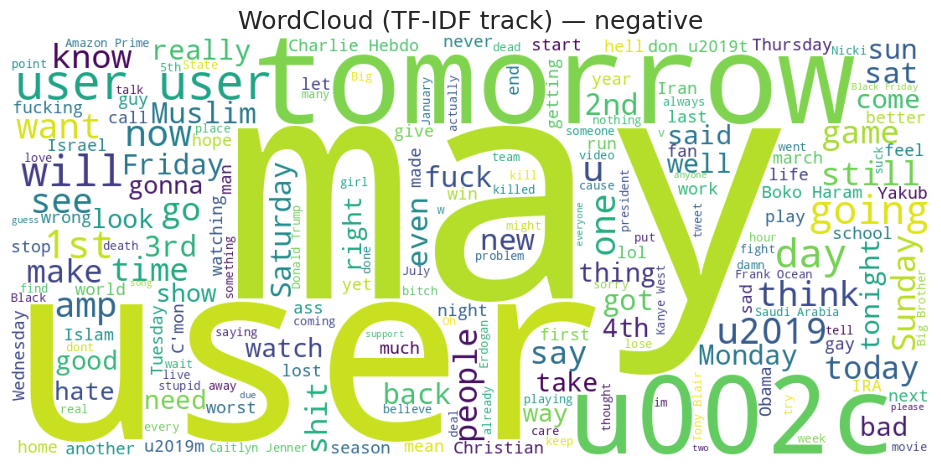

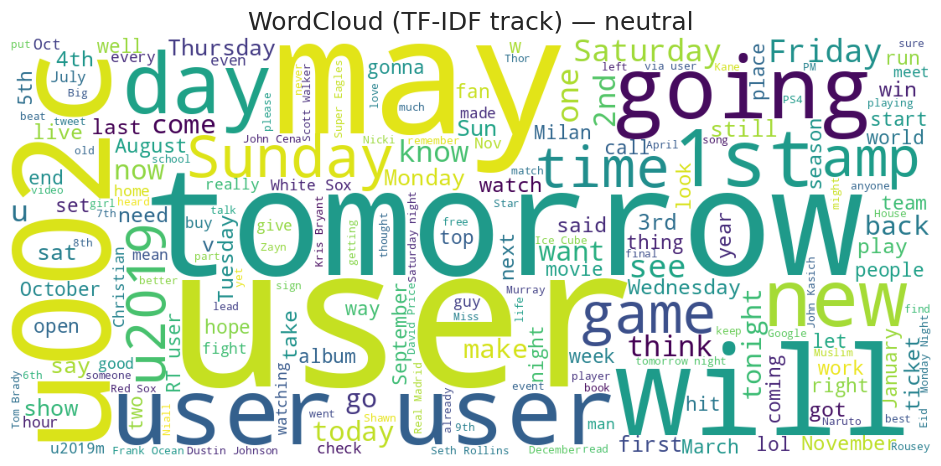

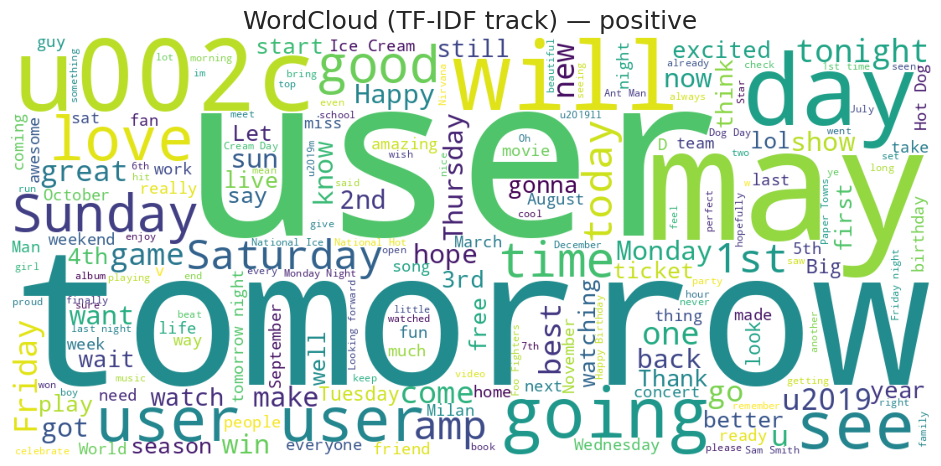

In [ ]:

# Word clouds (quick qualitative scan)
for lname in label_names:
    blob = " ".join(train_p.loc[train_p["label_name"] == lname, "text_tfidf"].tolist()[:8000])
    wc = WordCloud(width=1100, height=500, background_color="white").generate(blob)
    plt.figure(figsize=(11,5))
    plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud (TF‑IDF track) — {lname}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"wordcloud_{lname}.png"), dpi=150)
    plt.show()


## 6) Shared evaluation helpers

We compute the same metrics for both models so the comparison is fair.

In [ ]:

def eval_macro(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"{name} | Acc={acc:.4f} | Macro P={p:.4f} | Macro R={r:.4f} | Macro F1={f1:.4f}")
    return {"acc": acc, "macro_p": p, "macro_r": r, "macro_f1": f1}

def plot_cm(y_true, y_pred, title, out_png, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()


## 7) Model A — TF‑IDF baseline (strong + simple)

We train a strong classical baseline:
- TF‑IDF word (1,2)-grams
- Linear classifier

We keep it simple but robust by selecting a good `C` via small grid search.

Best TF‑IDF params: {'clf__C': 2.0}
TF‑IDF+LogReg (val) | Acc=0.6675 | Macro P=0.6376 | Macro R=0.6615 | Macro F1=0.6455
TF‑IDF+LogReg (test) | Acc=0.5947 | Macro P=0.5858 | Macro R=0.5996 | Macro F1=0.5911


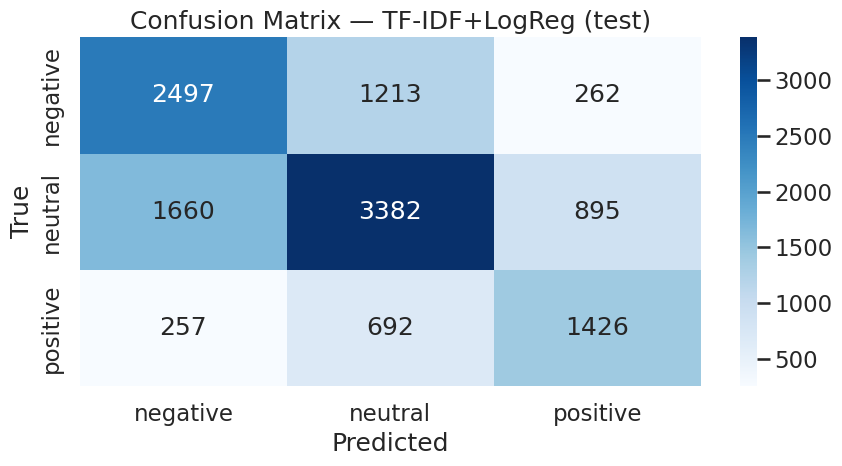


TF‑IDF classification report (test):

              precision    recall  f1-score   support

    negative     0.5657    0.6287    0.5955      3972
     neutral     0.6397    0.5696    0.6026      5937
    positive     0.5521    0.6004    0.5752      2375

    accuracy                         0.5947     12284
   macro avg     0.5858    0.5996    0.5911     12284
weighted avg     0.5988    0.5947    0.5950     12284



In [ ]:

X_train = train_p["text_tfidf"].tolist(); y_train = train_p["label"].values
X_val   = val_p["text_tfidf"].tolist();   y_val   = val_p["label"].values
X_test  = test_p["text_tfidf"].tolist();  y_test  = test_p["label"].values

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
        strip_accents="unicode",
        lowercase=True
    )),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

param_grid = {"clf__C": [0.5, 1.0, 2.0, 4.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

gs = GridSearchCV(pipe, param_grid=param_grid, scoring="f1_macro", cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

tfidf_best = gs.best_estimator_
print("Best TF‑IDF params:", gs.best_params_)

pred_val = tfidf_best.predict(X_val)
_ = eval_macro("TF‑IDF+LogReg (val)", y_val, pred_val)

pred_test_tfidf = tfidf_best.predict(X_test)
m_tfidf = eval_macro("TF‑IDF+LogReg (test)", y_test, pred_test_tfidf)

plot_cm(y_test, pred_test_tfidf,
        "Confusion Matrix — TF‑IDF+LogReg (test)",
        os.path.join(OUT_DIR, "cm_tfidf_test.png"),
        cmap="Blues")

print("\nTF‑IDF classification report (test):\n")
print(classification_report(y_test, pred_test_tfidf, target_names=label_names, digits=4))


### TF‑IDF explainability: top features per class

A nice advantage of linear TF‑IDF models is interpretability: we can list the highest‑weight n‑grams for each class.

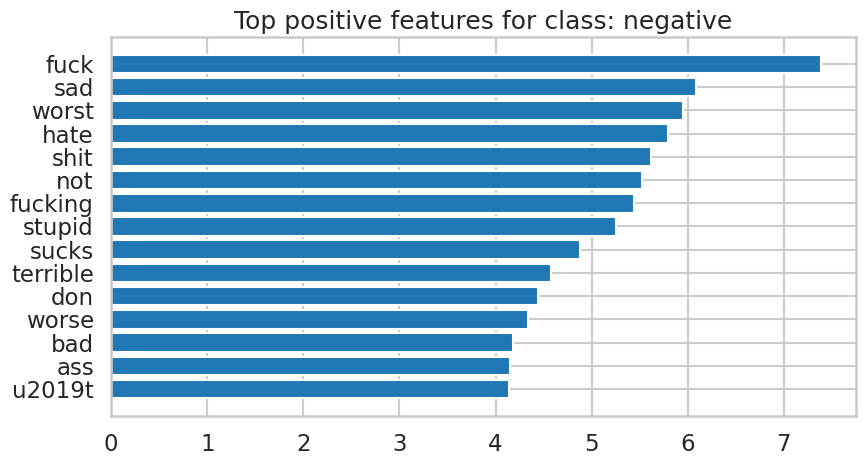

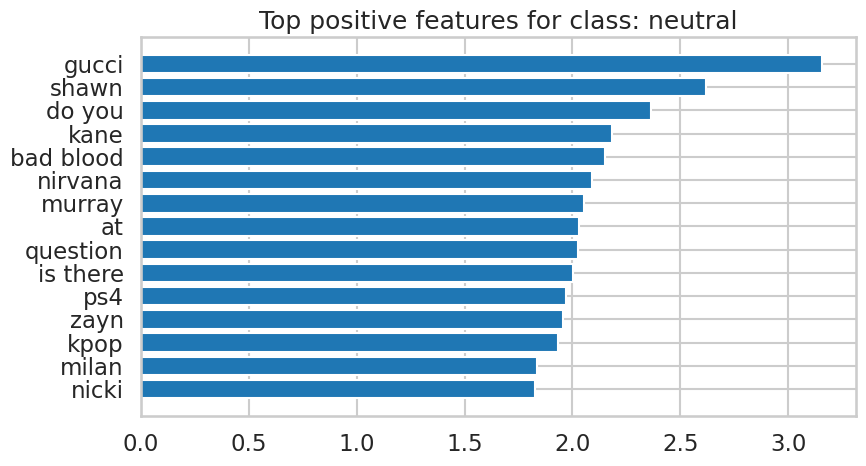

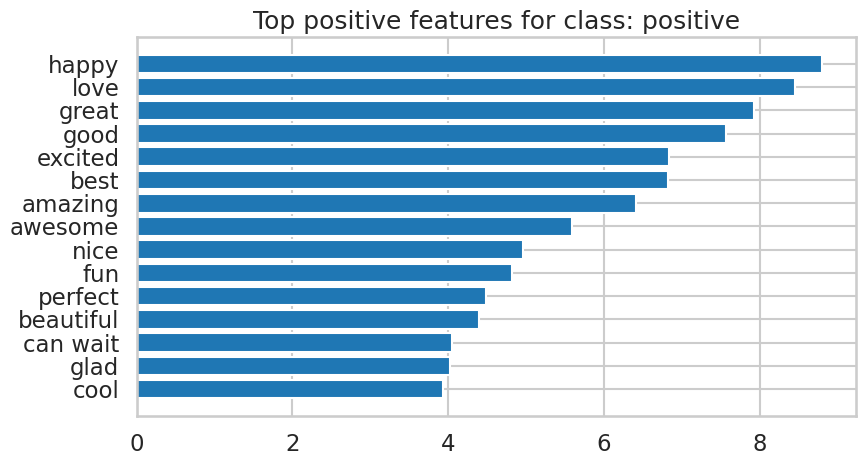

In [ ]:

vec = tfidf_best.named_steps["tfidf"]
clf = tfidf_best.named_steps["clf"]
feature_names = np.array(vec.get_feature_names_out())

def top_features_for_class(class_id, top_n=20):
    coefs = clf.coef_[class_id]
    top_pos = np.argsort(coefs)[-top_n:][::-1]
    top_neg = np.argsort(coefs)[:top_n]
    return feature_names[top_pos], coefs[top_pos], feature_names[top_neg], coefs[top_neg]

for cid, cname in enumerate(label_names):
    pos_feats, pos_w, neg_feats, neg_w = top_features_for_class(cid, top_n=15)
    df_top = pd.DataFrame({"feature": pos_feats, "weight": pos_w})
    plt.figure(figsize=(9,5))
    plt.barh(df_top["feature"][::-1], df_top["weight"][::-1])
    plt.title(f"Top positive features for class: {cname}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"tfidf_top_features_{cname}.png"), dpi=150)
    plt.show()


## 8) Model B — Transformer fine‑tune (Twitter‑pretrained RoBERTa)

We fine‑tune a transformer using the **`text_roberta`** column.

Default model choice (safe + simple):
- `cardiffnlp/twitter-roberta-base`

If you want a warm start from a sentiment‑tuned checkpoint, change to:
- `cardiffnlp/twitter-roberta-base-sentiment-latest`

In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base"  # optionally: "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# Build HF datasets from our preprocessed columns
train_ds = Dataset.from_pandas(train_p[["text_roberta", "label"]].rename(columns={"text_roberta":"text"}))
val_ds   = Dataset.from_pandas(val_p[["text_roberta", "label"]].rename(columns={"text_roberta":"text"}))
test_ds  = Dataset.from_pandas(test_p[["text_roberta", "label"]].rename(columns={"text_roberta":"text"}))

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

train_tok = train_ds.map(tokenize, batched=True, remove_columns=["text"])
val_tok   = val_ds.map(tokenize, batched=True, remove_columns=["text"])
test_tok  = test_ds.map(tokenize, batched=True, remove_columns=["text"])

collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "macro_precision": p, "macro_recall": r, "macro_f1": f1}

args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "transformer_ckpt"),
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-5,
    warmup_ratio=0.06,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    # Changed `tokenizer` to `data_collator` as `processing_class` is for processors.
    # The actual deprecation warning suggests using `processing_class`,
    # but `data_collator` handles the tokenization within the Trainer setup better.
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.587700,0.580907,0.740500,0.729427,0.717626,0.722655
2,0.462800,0.644181,0.744000,0.736272,0.712574,0.720909
3,0.315400,0.762730,0.743500,0.721562,0.729152,0.725062


TrainOutput(global_step=8553, training_loss=0.48438686099677397, metrics={'train_runtime': 866.5295, 'train_samples_per_second': 157.923, 'train_steps_per_second': 9.87, 'total_flos': 3039408089797968.0, 'train_loss': 0.48438686099677397, 'epoch': 3.0})

## 9) Transformer evaluation on test + comparison

Transformer test metrics: {'eval_loss': 0.7931891083717346, 'eval_accuracy': 0.7123086942364051, 'eval_macro_precision': 0.7039646437866914, 'eval_macro_recall': 0.7303465123572427, 'eval_macro_f1': 0.7140421208023976, 'eval_runtime': 9.9839, 'eval_samples_per_second': 1230.382, 'eval_steps_per_second': 19.231, 'epoch': 3.0}


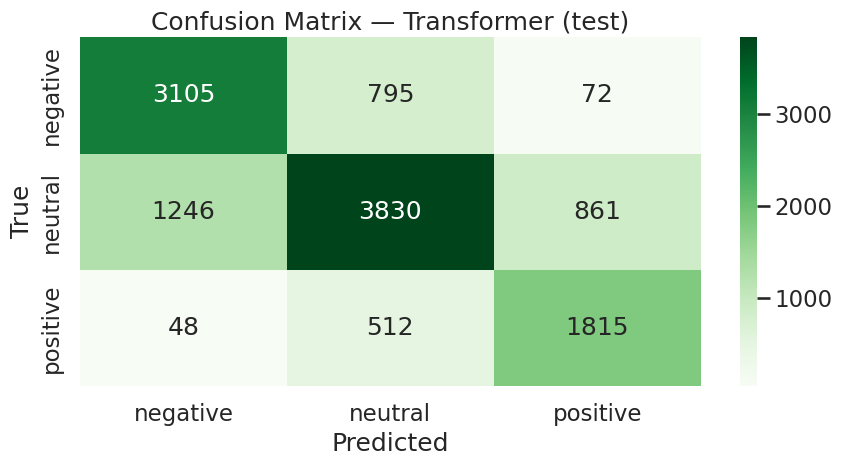


Transformer classification report (test):

              precision    recall  f1-score   support

    negative     0.7058    0.7817    0.7418      3972
     neutral     0.7456    0.6451    0.6917      5937
    positive     0.6605    0.7642    0.7086      2375

    accuracy                         0.7123     12284
   macro avg     0.7040    0.7303    0.7140     12284
weighted avg     0.7163    0.7123    0.7112     12284



,model,macro_f1,macro_recall,accuracy
1,Transformer (fine‑tuned),0.714042,0.730347,0.712309
0,TF‑IDF+LogReg,0.591128,0.599573,0.594676


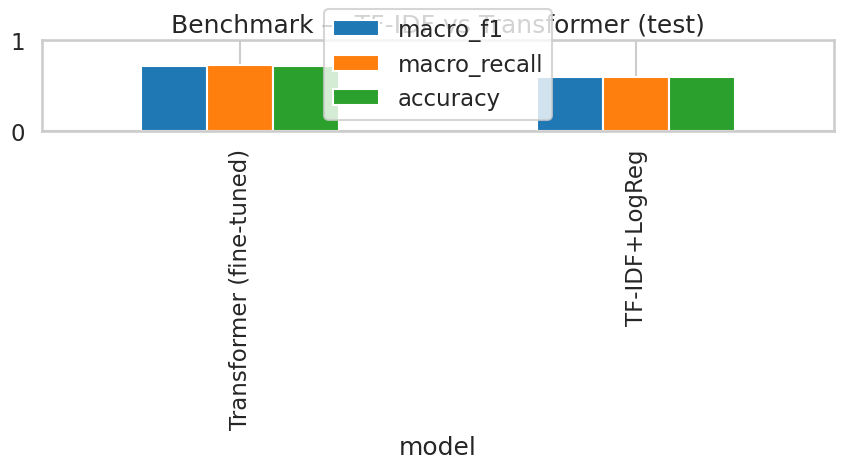

In [ ]:

tr_metrics = trainer.evaluate(test_tok)
print("Transformer test metrics:", tr_metrics)

pred_out = trainer.predict(test_tok)
pred_test_tr = np.argmax(pred_out.predictions, axis=1)

plot_cm(y_test, pred_test_tr,
        "Confusion Matrix — Transformer (test)",
        os.path.join(OUT_DIR, "cm_transformer_test.png"),
        cmap="Greens")

print("\nTransformer classification report (test):\n")
print(classification_report(y_test, pred_test_tr, target_names=label_names, digits=4))

bench = pd.DataFrame([
    {"model": "TF‑IDF+LogReg", "macro_f1": m_tfidf["macro_f1"], "macro_recall": m_tfidf["macro_r"], "accuracy": m_tfidf["acc"]},
    {"model": "Transformer (fine‑tuned)", "macro_f1": tr_metrics["eval_macro_f1"], "macro_recall": tr_metrics["eval_macro_recall"], "accuracy": tr_metrics["eval_accuracy"]},
]).sort_values("macro_f1", ascending=False)

display(bench)

ax = bench.set_index("model")[["macro_f1","macro_recall","accuracy"]].plot(kind="bar", ylim=(0,1))
ax.set_title("Benchmark — TF‑IDF vs Transformer (test)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "benchmark_bar.png"), dpi=150)
plt.show()


## 10) Error analysis: what the transformer improves

We inspect where the transformer is correct but TF‑IDF is wrong (and vice‑versa).  
This gives evidence beyond a single metric and supports your discussion section.

In [ ]:

# Identify disagreements
tfidf_correct = (pred_test_tfidf == y_test)
tr_correct = (pred_test_tr == y_test)

improve_idx = np.where((~tfidf_correct) & (tr_correct))[0]
regress_idx = np.where((tfidf_correct) & (~tr_correct))[0]

def show_examples(idxs, title, n=8):
    print("\n" + title)
    take = idxs[:n] if len(idxs) > 0 else []
    rows = []
    for i in take:
        rows.append({
            "text": test_p.iloc[i]["text_raw"],
            "true": label_names[int(y_test[i])],
            "tfidf": label_names[int(pred_test_tfidf[i])],
            "transformer": label_names[int(pred_test_tr[i])]
        })
    return pd.DataFrame(rows)

display(show_examples(improve_idx, "Transformer correct, TF‑IDF wrong (examples)", n=10))
display(show_examples(regress_idx, "TF‑IDF correct, Transformer wrong (examples)", n=10))



Transformer correct, TF‑IDF wrong (examples)


,text,true,tfidf,transformer
0,Twitter's #ThankYouObama Shows Heartfelt Grati...,positive,neutral,positive
1,"When Ryan privatizes SS, Medicare, Medicaid, &...",negative,neutral,negative
2,Swampbitch Nasty Pelosi loves yelling 'Fire' ...,negative,positive,negative
3,"Christians In Palestine: Yes, They Exist #gaza...",neutral,negative,neutral
4,Zac Efron Flaunts Fit Abs in New ‘Dirty Grandp...,neutral,positive,neutral
5,When Jesse Jackson Cozied Up to Fidel Castro,neutral,positive,neutral
6,@user @user Trump is likely supporting Putin t...,neutral,negative,neutral
7,Photos: A Thanksgiving protest against Dakota ...,neutral,negative,neutral
8,@user @user @user @user Clinton foundation rem...,negative,neutral,negative
9,When Trump jeopardizes their social security a...,negative,neutral,negative



TF‑IDF correct, Transformer wrong (examples)


,text,true,tfidf,transformer
0,@user @user @user @user @user @user take away ...,negative,negative,neutral
1,Ben Carson awoke this morning to find out that...,neutral,neutral,positive
2,Next?#draintheswamp #TimeForChange#TrumpTransi...,neutral,neutral,negative
3,Grayson Allen just gave dude such a sick move,negative,negative,positive
4,"Download UBER app, Register with this promo co...",neutral,neutral,positive
5,idk where to start after my intro. im writing ...,neutral,neutral,negative
6,#Yanukovych seems much more willing to take qu...,neutral,neutral,positive
7,@user @user @user @user ☞ ISIS Films Men Laugh...,negative,negative,neutral
8,@user Wow...this is one deadly statement! Remi...,positive,positive,negative
9,@user @user @user @user You mean like Nancy Pe...,neutral,neutral,negative


In [ ]:

# Save benchmark table
bench.to_csv(os.path.join(OUT_DIR, "benchmark_table.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "benchmark_table.csv"))
print("Saved plots in:", OUT_DIR)


Saved: outputs/benchmark_table.csv
Saved plots in: outputs
